**Stage 1: Install & Import Required Libraries**

In [47]:
import os
import zipfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


**Stage 2: Upload and Extract Dataset ZIP**

In [48]:
uploaded = files.upload()
zip_path = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_dataset")

subfolders = list(Path("brain_tumor_dataset").glob("*"))
dataset_path = subfolders[0]
print(f"Dataset root folder detected: {dataset_path}")

Saving brain_tumor_dataset.zip to brain_tumor_dataset (5).zip
Dataset root folder detected: brain_tumor_dataset/brain_tumor_dataset


**Stage 3: Load Data and Create DataFrame**

'yes' folder contains 155 images.
'no' folder contains 98 images.


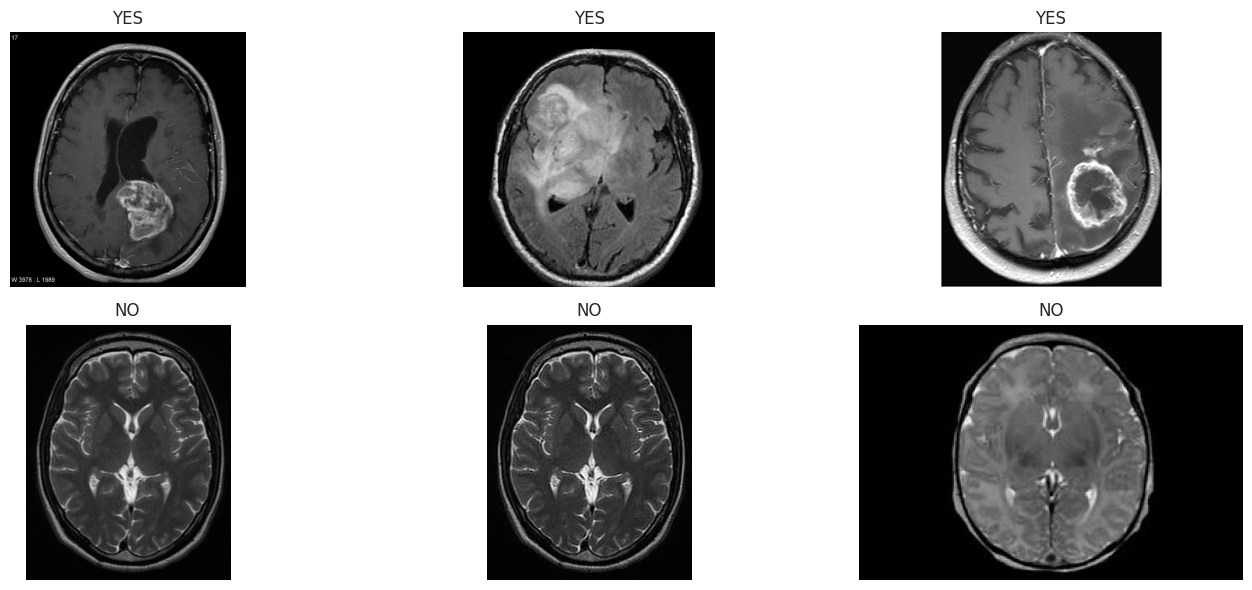

In [49]:
filepaths = []
labels = []

for label in ["yes", "no"]:
    folder = dataset_path / label
    image_files = os.listdir(folder)
    print(f"'{label}' folder contains {len(image_files)} images.")

    for filename in image_files:
        filepaths.append(str(folder / filename))
        labels.append(label)

df = pd.DataFrame({"filepaths": filepaths, "label": labels})


fig, axs = plt.subplots(2, 3, figsize=(15, 6))

for i, label in enumerate(["yes", "no"]):
    class_df = df[df["label"] == label].sample(3, random_state=42)
    for j, path in enumerate(class_df["filepaths"].values):
        img = Image.open(path)
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")
        axs[i, j].set_title(label.upper())

plt.tight_layout()
plt.show()


**Stage 4: Train/Validation/Test Split**

In [50]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Train: 181, Valid: 21, Test: 51


**Stage 5: Data Generators (with Preprocessing and Augmentation)**

In [51]:
img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, zoom_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, horizontal_flip=True
).flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='binary', shuffle=True, batch_size=batch_size)

valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='binary', shuffle=False, batch_size=batch_size)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    test_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='binary', shuffle=False, batch_size=batch_size)

Found 181 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


**Stage 6: Build ResNet50 Model**

In [52]:
inputs = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_tensor=inputs)
for layer in base_model.layers:
    layer.trainable = False

x = BatchNormalization()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

**Stage 7: Train the Model**

In [53]:
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(train_gen, validation_data=valid_gen, epochs=30, callbacks=[checkpoint, early_stop])

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.3385 - loss: 1.1980 - val_accuracy: 0.4762 - val_loss: 0.8313
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.4182 - loss: 1.2150 - val_accuracy: 0.4762 - val_loss: 0.8068
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.4506 - loss: 1.0951 - val_accuracy: 0.4762 - val_loss: 0.7823
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.5361 - loss: 0.9437 - val_accuracy: 0.4762 - val_loss: 0.7585
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.4216 - loss: 1.1376 - val_accuracy: 0.5238 - val_loss: 0.7371
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.5599 - loss: 1.0080 - val_accuracy: 0.5238 - val_loss: 0.7172
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.4974 - loss: 0.9620 - val_accuracy: 0.5714 - val_loss: 0.7001
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.5197 - loss: 1.0784 - val_accuracy: 0.5714 - val_loss: 0.6846
Epoch 9/

**Stage 8: Visualize Training Curves**

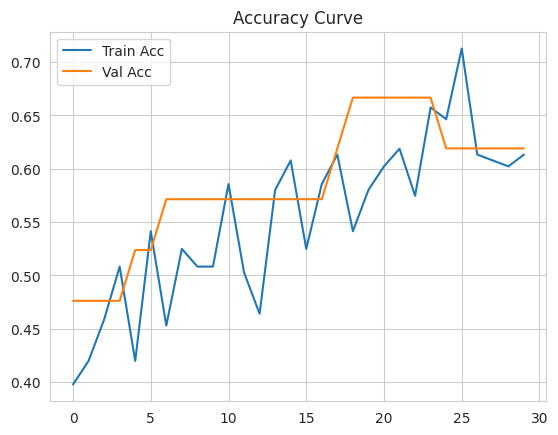

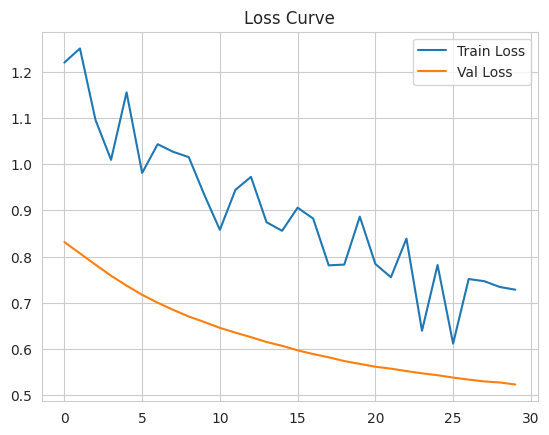

In [54]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy Curve"); plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss Curve"); plt.show()

**Stage 9: Evaluate Final Metrics**

In [55]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Train Accuracy:       {final_train_acc:.4f}")
print(f"Final Validation Accuracy:  {final_val_acc:.4f}")


model = load_model("best_model.keras")
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.4f}")

Final Train Accuracy:       0.6133
Final Validation Accuracy:  0.6190
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7128 - loss: 0.5618
Test Accuracy: 0.7255


**Stage 10: Confusion Matrix & Classification Report**

1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


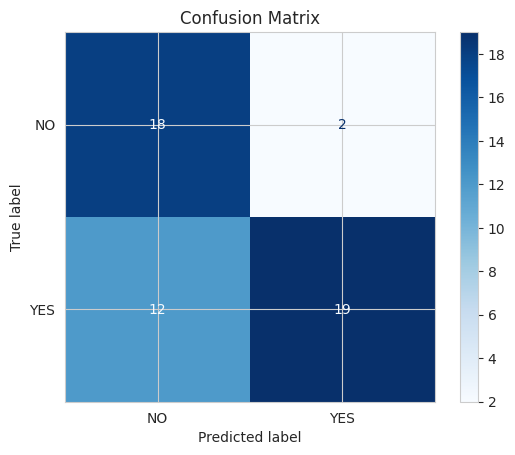

              precision    recall  f1-score   support

          NO       0.60      0.90      0.72        20
         YES       0.90      0.61      0.73        31

    accuracy                           0.73        51
   macro avg       0.75      0.76      0.73        51
weighted avg       0.79      0.73      0.73        51



In [56]:
y_true = test_gen.labels
y_pred_probs = model.predict(test_gen).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)
labels = ["NO", "YES"]
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))

**Stage 11:Test Images**

Saving Test.zip to Test (3).zip
Found 8 images in Test/Test


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


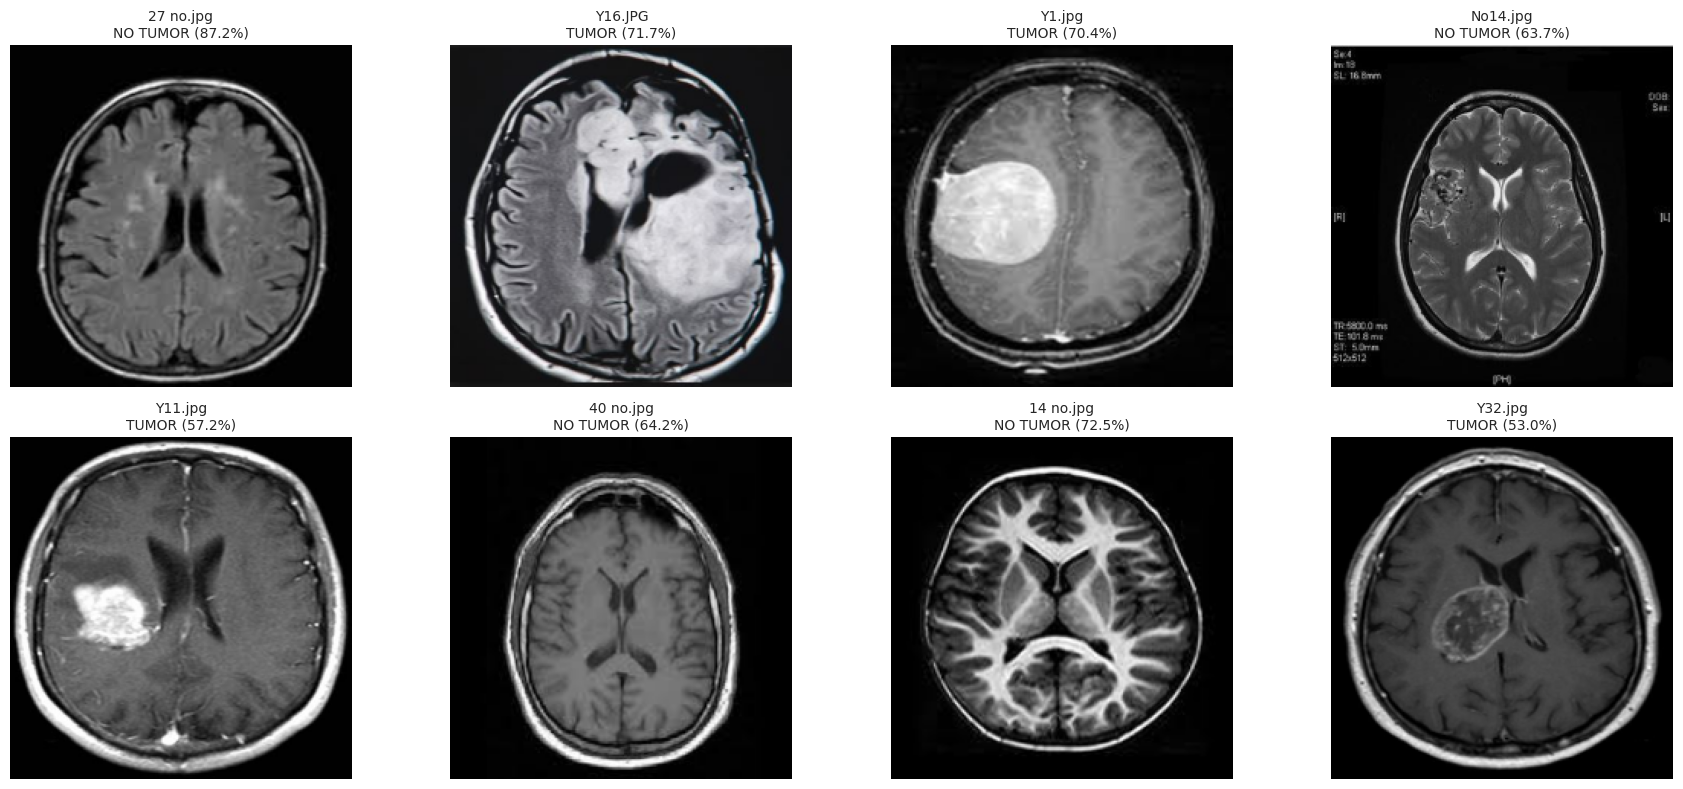

In [57]:
uploaded = files.upload()
zip_path = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("Test")

test_folder = Path("Test/Test")
image_paths = list(test_folder.glob("*"))
print(f"Found {len(image_paths)} images in {test_folder}")

img_size = (224, 224)
cols = 4
rows = int(np.ceil(len(image_paths) / cols))
plt.figure(figsize=(18, rows * 4))

for i, path in enumerate(image_paths):
    img_bgr = cv2.imread(str(path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, img_size)

    img_display = img_resized.copy()
    img_input = preprocess_input(img_resized.copy())

    pred_prob = model.predict(np.expand_dims(img_input, axis=0))[0][0]
    pred_label = "TUMOR" if pred_prob > 0.5 else "NO TUMOR"
    confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_display.astype('uint8'))
    plt.title(f"{path.name}\n{pred_label} ({confidence*100:.1f}%)", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [46]:
from google.colab import files
files.download('best_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>